In [5]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard ,Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score,roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
import time
import math
warnings.filterwarnings('ignore')
from ultralytics import YOLO, __version__ as ultralytics_version
import torch
import shutil

# Image Processing and Differential Count Calculation

#####  Loads YOLOv8 and CNN models, processes input images to detect and classify white blood cells, calculates the differential count for each image, and saves annotated images and results as text files in the output directory. It also computes the overall differential count across all images.

In [15]:
yolo_model_path = "C:/Users/ASUS/Desktop/Projet2_JY/runs/detect/yolov8n_final_cpu9/weights/best.pt"
classifier_model_path = "C:/Users/ASUS/Desktop/Projet2_JY/best_model.h5"
input_images_dir = "D:/Project2/test_images/"
output_dir = "D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created or exists: {output_dir}")

yolo_model = YOLO(yolo_model_path)
classifier_model = load_model(classifier_model_path)
classifier_input_size = (224, 224)
class_names = ['Normal_Neutrophils', 'Normal_Lymphocytes', 'Normal_Eosinophils', 
               'Normal_Monocytes', 'Normal_Basophils']
yolo_to_cnn_mapping = {
    'neutrophil': 'Normal_Neutrophils',
    'lymphocyte': 'Normal_Lymphocytes',
    'eosinophil': 'Normal_Eosinophils',
    'monocyte': 'Normal_Monocytes',
    'basophil': 'Normal_Basophils'
}
yolo_valid_classes = list(yolo_to_cnn_mapping.keys())

def preprocess_for_classifier(image, target_size):
    image = cv2.resize(image, target_size)
    image = img_to_array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

differential_count = {cls: 0 for cls in class_names}
cnn_differential_count = {cls: 0 for cls in class_names}
image_results = []

for image_name in os.listdir(input_images_dir):
    if image_name.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_images_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image {image_path}")
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = yolo_model.predict(image_path, conf=0.25, iou=0.6)
        image_differential_count = {cls: 0 for cls in class_names}
        image_cnn_count = {cls: 0 for cls in class_names}
        classification_results = []
        unknown_count = 0

        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            confidences = result.boxes.conf.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy().astype(int)
            annotated_image = image_rgb.copy()

            print(f"Number of cells detected by YOLO in {image_name}: {len(boxes)}")

            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                confidence = confidences[i]
                yolo_class_name = yolo_model.names[class_ids[i]]
                if yolo_class_name not in yolo_valid_classes:
                    print(f"Skipping cell {i} in {image_name}: YOLO detected as {yolo_class_name}")
                    continue
                yolo_mapped_class = yolo_to_cnn_mapping[yolo_class_name]
                image_differential_count[yolo_mapped_class] += 1
                cropped_cell = image_rgb[y1:y2, x1:x2]
                if cropped_cell.size == 0:
                    print(f"Skipping cell {i} in {image_name}: Empty cropped cell")
                    continue
                processed_cell = preprocess_for_classifier(cropped_cell, classifier_input_size)
                prediction = classifier_model.predict(processed_cell, verbose=0)
                print(f"Raw prediction for cell {i} in {image_name}: {prediction[0]}")
                predicted_class_idx = np.argmax(prediction[0])
                model_class_names = ['Normal_Neutrophils', 'Normal_Lymphocytes', 'Normal_Eosinophils', 
                                     'Normal_Monocytes', 'Normal_Basophils', 'Blast', 'RBC']
                cnn_predicted_class = model_class_names[predicted_class_idx] if predicted_class_idx < len(model_class_names) else 'Unknown'
                if cnn_predicted_class not in class_names:
                    unknown_count += 1
                    print(f"Cell {i} in {image_name} classified as {cnn_predicted_class} (skipped)")
                    continue
                class_prob = prediction[0][predicted_class_idx]
                image_cnn_count[cnn_predicted_class] += 1
                classification_results.append({
                    'box': box,
                    'confidence': confidence,
                    'yolo_class': yolo_mapped_class,
                    'cnn_class': cnn_predicted_class,
                    'probability': class_prob
                })

                color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
                cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
                label = f"YOLO: {yolo_mapped_class}, CNN: {cnn_predicted_class} ({class_prob:.2f})"
                cv2.putText(annotated_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            print(f"Unknown cells in {image_name}: {unknown_count}")

            total_wbc = sum(image_differential_count.values())
            differential_percentages = {
                cls: (count / total_wbc * 100) if total_wbc > 0 else 0
                for cls, count in image_differential_count.items()
            }

            differential_df = pd.DataFrame({
                'Cell Type': class_names,
                'Count': [image_differential_count[cls] for cls in class_names],
                'Percentage (%)': [differential_percentages[cls] for cls in class_names]
            })

            total_cnn_wbc = sum(image_cnn_count.values())
            cnn_percentages = {
                cls: (count / total_cnn_wbc * 100) if total_cnn_wbc > 0 else 0
                for cls, count in image_cnn_count.items()
            }
            cnn_differential_df = pd.DataFrame({
                'Cell Type': class_names,
                'Count': [image_cnn_count[cls] for cls in class_names],
                'Percentage (%)': [cnn_percentages[cls] for cls in class_names]
            })

            for cls in class_names:
                differential_count[cls] += image_differential_count[cls]
                cnn_differential_count[cls] += image_cnn_count[cls]

            output_image_path = os.path.join(output_dir, f"annotated_{image_name}")
            cv2.imwrite(output_image_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
            print(f"Saved annotated image: {output_image_path}")

            output_text_path = os.path.join(output_dir, f"results_{image_name}.txt")
            with open(output_text_path, "w", encoding='utf-8') as f:
                f.write(f"Differential Count for {image_name} (YOLO):\n")
                f.write(differential_df.to_string(index=False))
                f.write("\n\nDifferential Count for {image_name} (CNN):\n")
                f.write(cnn_differential_df.to_string(index=False))
                f.write("\n\nClassification Results:\n")
                for res in classification_results:
                    f.write(f"Box: {res['box']}, Confidence: {res['confidence']:.4f}, YOLO Class: {res['yolo_class']}, CNN Class: {res['cnn_class']}, Probability: {res['probability']:.4f}\n")
            print(f"Saved results text: {output_text_path}")

            image_results.append({
                'image_name': image_name,
                'differential_df': differential_df,
                'cnn_differential_df': cnn_differential_df,
                'annotated_image': annotated_image
            })

overall_differential_df = pd.DataFrame({
    'Cell Type': class_names,
    'Count': [differential_count[cls] for cls in class_names],
    'Percentage (%)': [(count / sum(differential_count.values()) * 100) if sum(differential_count.values()) > 0 else 0 for count in differential_count.values()]
})

overall_cnn_differential_df = pd.DataFrame({
    'Cell Type': class_names,
    'Count': [cnn_differential_count[cls] for cls in class_names],
    'Percentage (%)': [(count / sum(cnn_differential_count.values()) * 100) if sum(cnn_differential_count.values()) > 0 else 0 for count in cnn_differential_count.values()]
})

output_overall_text_path = os.path.join(output_dir, "overall_differential_count.txt")
with open(output_overall_text_path, "w", encoding='utf-8') as f:
    f.write("Overall Differential Count for All Images (YOLO):\n")
    f.write(overall_differential_df.to_string(index=False))
    f.write("\n\nOverall Differential Count for All Images (CNN):\n")
    f.write(overall_cnn_differential_df.to_string(index=False))
print(f"Saved overall differential count: {output_overall_text_path}")

print(f"Combined results saved in {output_dir}")

Output directory created or exists: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results



image 1/1 D:\Project2\test_images\20161031_154000.png: 384x640 1 neutrophil, 225.0ms
Speed: 10.2ms preprocess, 225.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Number of cells detected by YOLO in 20161031_154000.png: 1
Raw prediction for cell 0 in 20161031_154000.png: [    0.18014    0.040049    0.012168     0.45309     0.10447    0.059019     0.15107]
Unknown cells in 20161031_154000.png: 0
Saved annotated image: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\annotated_20161031_154000.png
Saved results text: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\results_20161031_154000.png.txt

image 1/1 D:\Project2\test_images\20161031_162223.png: 384x640 1 blast, 185.8ms
Speed: 6.2ms preprocess, 185.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Number of cells detected by YOLO in 20161031_162223.png: 1
Skipping cell 0 in 20161031_162223.png: YOLO detected as blast
Unknown cells in 20161031_162223.png: 0
Saved annotate

## Visualization of Results


Differential Count for 20161031_154000.png:


,Cell Type,Count,Percentage (%)
0,Normal_Neutrophils,1,100.0
1,Normal_Lymphocytes,0,0.0
2,Normal_Eosinophils,0,0.0
3,Normal_Monocytes,0,0.0
4,Normal_Basophils,0,0.0


Saved differential count plot: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\differential_count_20161031_154000.png


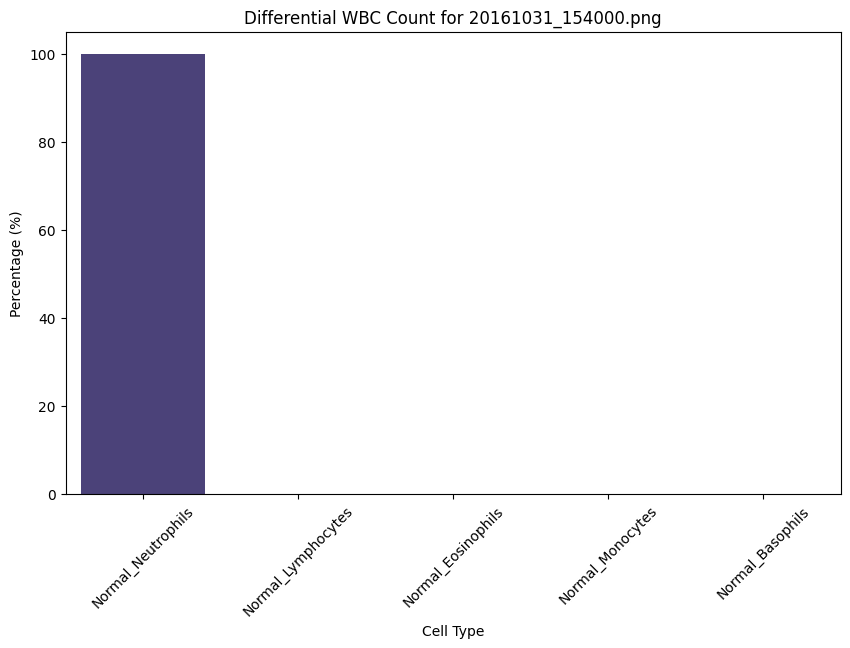

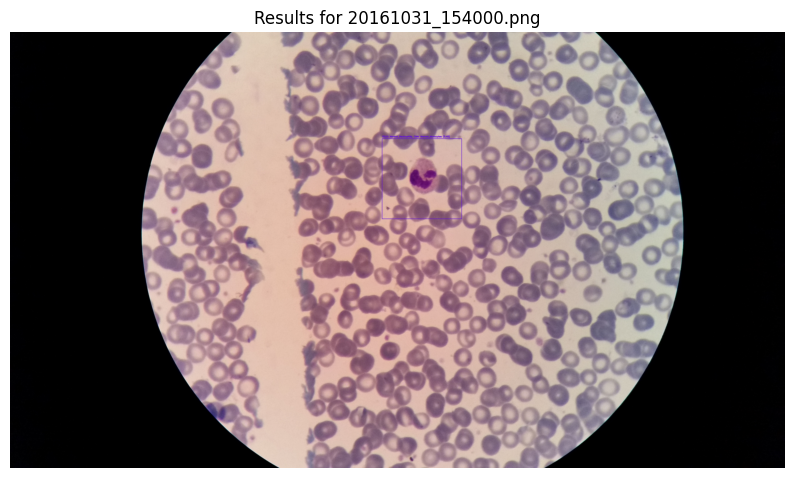


Differential Count for 20161031_162223.png:


,Cell Type,Count,Percentage (%)
0,Normal_Neutrophils,0,0
1,Normal_Lymphocytes,0,0
2,Normal_Eosinophils,0,0
3,Normal_Monocytes,0,0
4,Normal_Basophils,0,0


Saved differential count plot: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\differential_count_20161031_162223.png


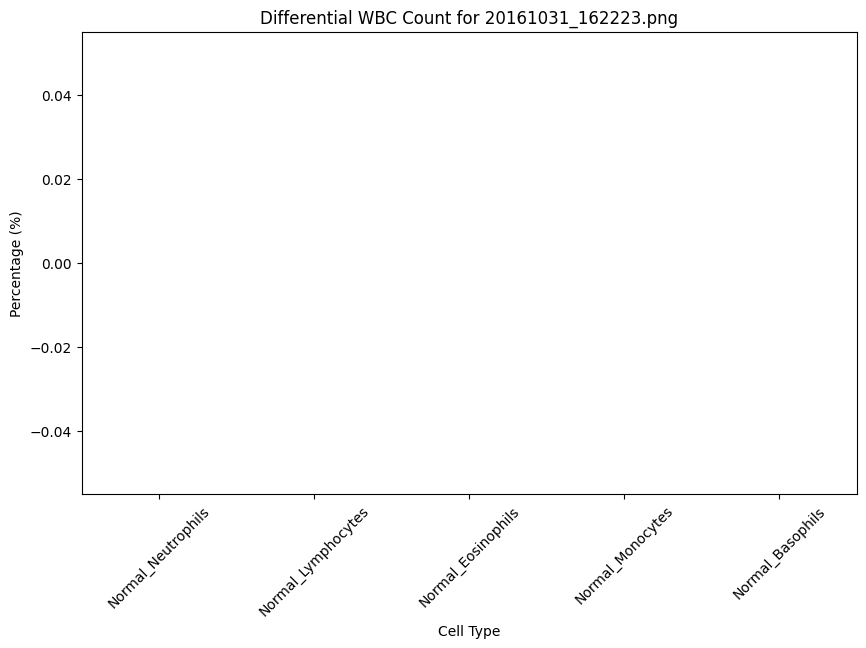

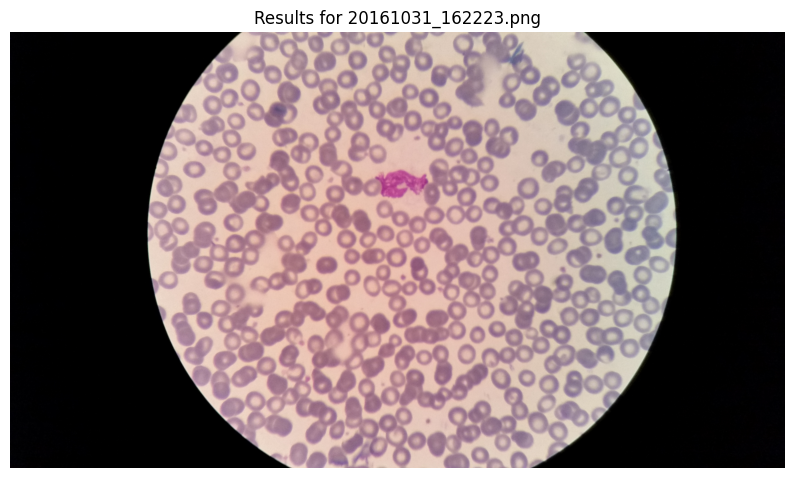


Differential Count for 20161031_162330.png:


,Cell Type,Count,Percentage (%)
0,Normal_Neutrophils,2,66.666667
1,Normal_Lymphocytes,0,0.000000
2,Normal_Eosinophils,0,0.000000
3,Normal_Monocytes,1,33.333333
4,Normal_Basophils,0,0.000000


Saved differential count plot: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\differential_count_20161031_162330.png


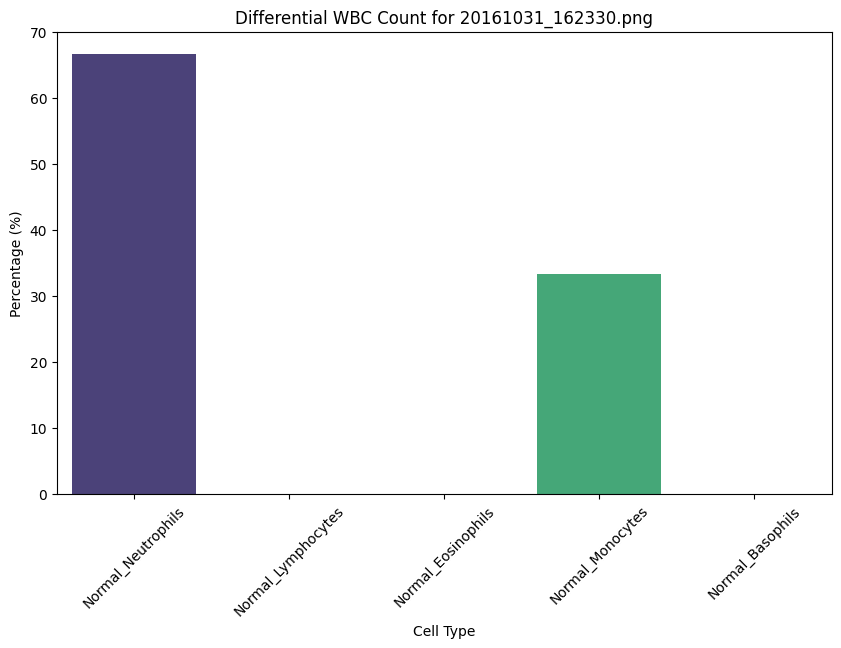

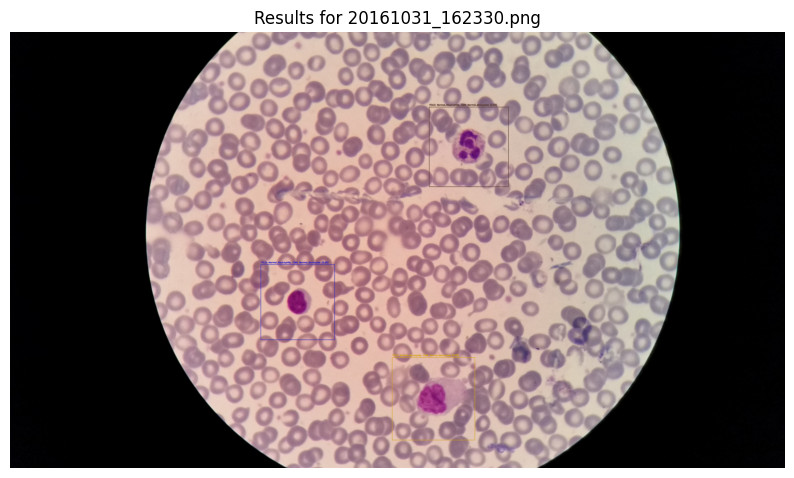


Differential Count for 20161031_162338.png:


,Cell Type,Count,Percentage (%)
0,Normal_Neutrophils,0,0.0
1,Normal_Lymphocytes,0,0.0
2,Normal_Eosinophils,0,0.0
3,Normal_Monocytes,1,100.0
4,Normal_Basophils,0,0.0


Saved differential count plot: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\differential_count_20161031_162338.png


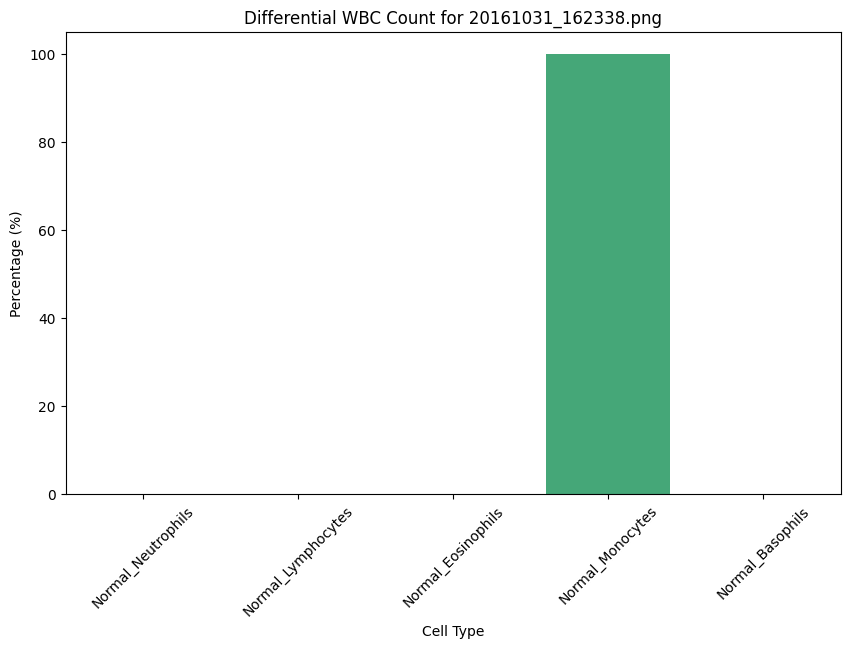

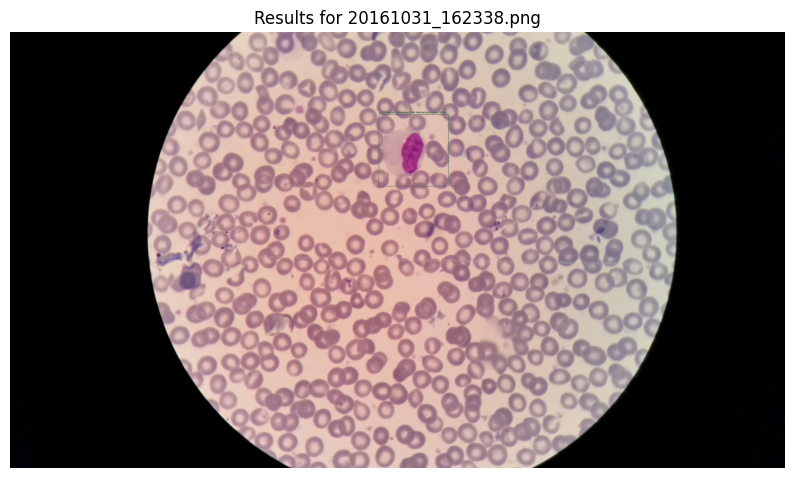


Differential Count for 20161031_162345.png:


,Cell Type,Count,Percentage (%)
0,Normal_Neutrophils,0,0
1,Normal_Lymphocytes,0,0
2,Normal_Eosinophils,0,0
3,Normal_Monocytes,0,0
4,Normal_Basophils,0,0


Saved differential count plot: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\differential_count_20161031_162345.png


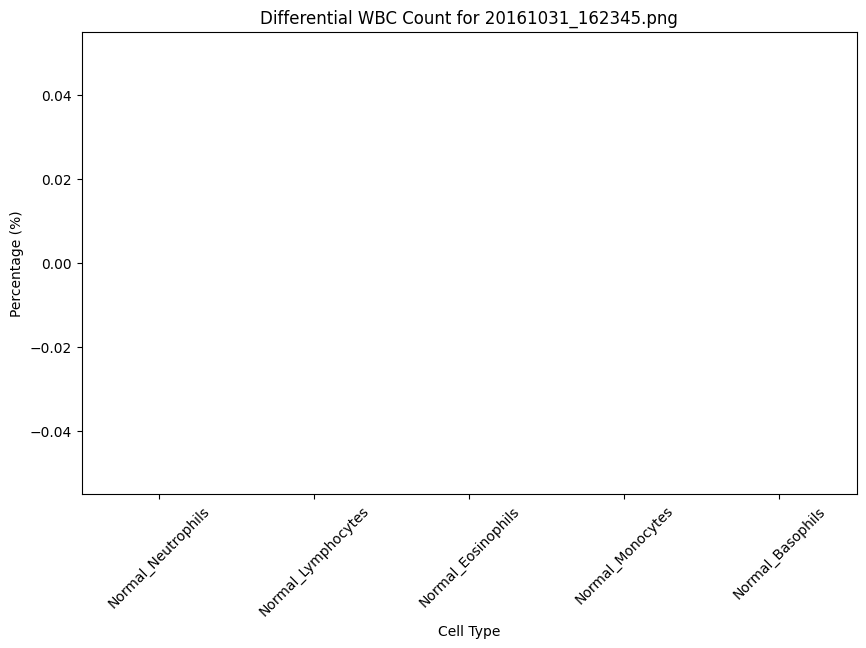

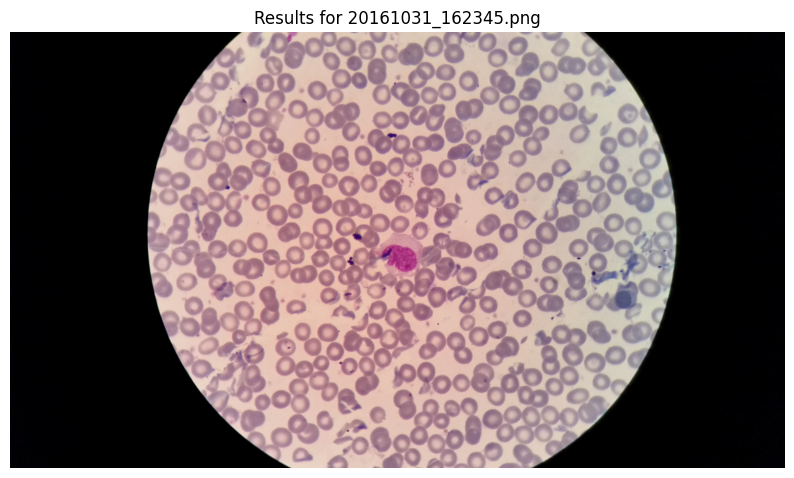


Differential Count for 20161031_162351.png:


,Cell Type,Count,Percentage (%)
0,Normal_Neutrophils,0,0.0
1,Normal_Lymphocytes,0,0.0
2,Normal_Eosinophils,0,0.0
3,Normal_Monocytes,1,100.0
4,Normal_Basophils,0,0.0


Saved differential count plot: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\differential_count_20161031_162351.png


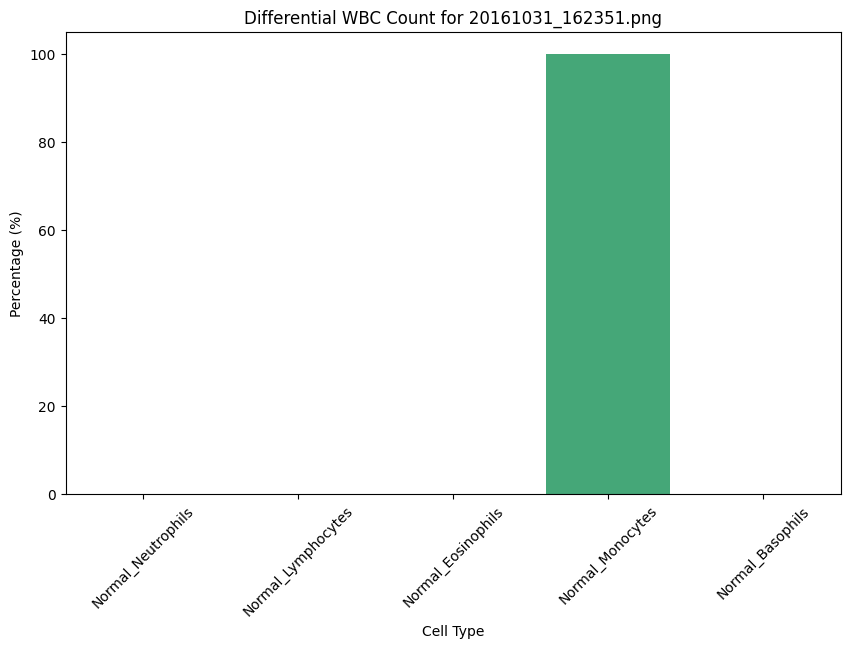

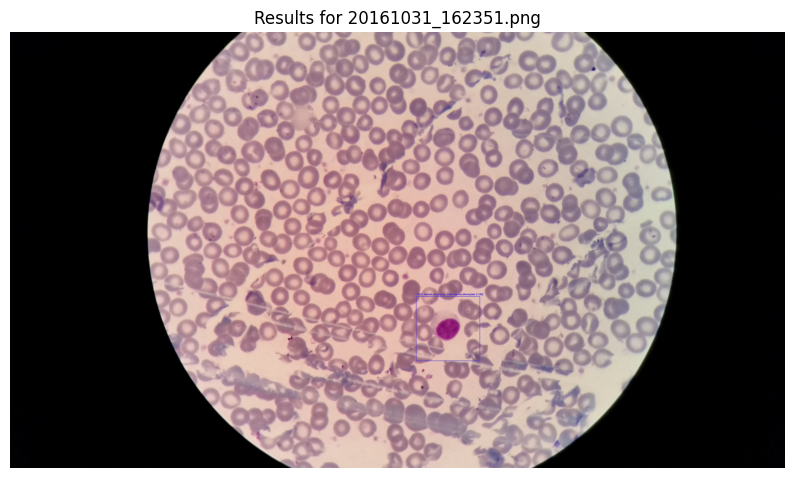


Overall Differential Count for All Images:


,Cell Type,Count,Percentage (%)
0,Normal_Neutrophils,3,50.0
1,Normal_Lymphocytes,0,0.0
2,Normal_Eosinophils,0,0.0
3,Normal_Monocytes,3,50.0
4,Normal_Basophils,0,0.0


Saved overall differential count plot: D:/Project2/runs/detect/yolov8n_final_cpu9/combined_results\overall_differential_count.png


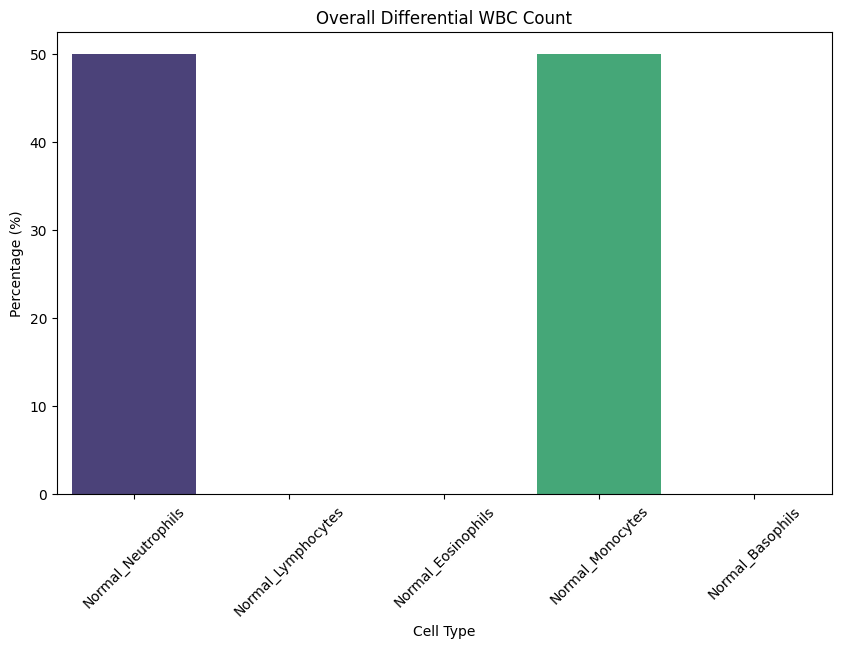

In [16]:
for result in image_results:
    image_name = result['image_name']
    differential_df = result['differential_df']
    annotated_image = result['annotated_image']
    
    print(f"\nDifferential Count for {image_name}:")
    display(differential_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Cell Type', y='Percentage (%)', data=differential_df, palette='viridis')
    plt.title(f'Differential WBC Count for {image_name}')
    plt.xticks(rotation=45)
    plt.ylabel('Percentage (%)')
    output_plot_path = os.path.join(output_dir, f'differential_count_{image_name}')
    try:
        plt.savefig(output_plot_path, bbox_inches='tight')
        print(f"Saved differential count plot: {output_plot_path}")
    except Exception as e:
        print(f"Error saving differential count plot {output_plot_path}: {e}")
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image)
    plt.title(f"Results for {image_name}")
    plt.axis('off')
    plt.show()

print("\nOverall Differential Count for All Images:")
display(overall_differential_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Cell Type', y='Percentage (%)', data=overall_differential_df, palette='viridis')
plt.title('Overall Differential WBC Count')
plt.xticks(rotation=45)
plt.ylabel('Percentage (%)')
output_overall_plot_path = os.path.join(output_dir, 'overall_differential_count.png')
try:
    plt.savefig(output_overall_plot_path, bbox_inches='tight')
    print(f"Saved overall differential count plot: {output_overall_plot_path}")
except Exception as e:
    print(f"Error saving overall differential count plot {output_overall_plot_path}: {e}")
plt.show()